# Enhanced Sampling Simulations
## with Ensembler

In this notebook, we give examples for enhanced sampling simulation with Ensembler. We show how to execute, visualize, and analyze those simulations for both 1D and 2D systems.

The enhanced sampling technologies are briefly explained in order to directly use this notebook for teaching purpose.

Maintainers: [@SchroederB](https://https://github.com/SchroederB), [@linkerst](https://https://github.com/linkerst), [@dfhahn](https://https://github.com/dfhahn)

## Loading Ensembler and necessary external packages 

In [1]:
import os, sys
my_path = os.getcwd()+"/.."
print(my_path)
sys.path.append(my_path)

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from ensembler.potentials.OneD import fourWellPotential, harmonicOscillatorPotential
from ensembler.potentials.TwoD import harmonicOscillatorPotential as harmonicOscillator2D,  wavePotential as wavePotential2D, gaussPotential

from ensembler.potentials.biased_potentials.biasOneD import addedPotentials, metadynamicsPotential
from ensembler.potentials.biased_potentials.biasTwoD import addedPotentials as addedPotentials2D, metadynamicsPotential as metadynamicsPotential2D
from ensembler.samplers.stochastic import langevinIntegrator
from ensembler.system import system

##Visualisation
from ensembler.visualisation.plotSimulations import static_sim_plots, static_sim_plots_bias

C:\Users\benja\OneDrive - ETH Zürich\PhD\Code\ensembler_public\examples/..


## Enhanced Sampling Simulations in 1D

### Unbiased System

We start our walkthrough with an unbiased reference simulation of a four-well-potential and give a small introduction in how to set up a simulation with Ensembler. To define the four-well-potential one has to define the x-positions ($a$-$d$) of the four wells. The y-position of the wells is defined by the parameters $ah$ - $dh$. If wished, the potential can also be scaled in the y-direction using $V_{max}$. Note that the energy is given in units of $k_BT$.  

In [2]:
# Simulation Setup
pot = fourWellPotential(Vmax=4, a=1.5, b=4.0, c=7.0, d=9.0,  ah=2., bh=0., ch=0.5, dh=1.)

For the numeric integration of our system we choose the stochastic Langevin integrator. As arguments one has to choose the step size $dt$ and the friction coefficient $gamma$. Note that this integrator already includes a thermostat. The temperature of the simulation will be set during the system setup (see below).

In [3]:
# Simple Langevin integration simulation
integrator = langevinIntegrator(dt=0.1, gamma=15)

The system wraps the integrator and the potential. Additionally, the initial system of the particle $position$ as well as the temperature parameter $temperature$ are set.

In [4]:
# Put Potential and Integrator together to generate the simulation system 
system1 = system(potential=pot, sampler=integrator,  start_position=4.2,  temperature=1)

To start the simulation we define the number of steps and run `sys.simulate()`. The progress of the simulation is displayed by a progress bar.

In [42]:
#simulate
sim_steps = 2000
cur_state = system1.simulate(sim_steps, withdraw_traj=True, init_system=False)

print("Trajectory length: ",len(system1.trajectory))
print()
print("last_state: ", cur_state)
print(len(system1.trajectory))

initializing Langevin old Positions	 



Trajectory length:  2001

last_state:  State(position=4.157280245750426, temperature=1, total_system_energy=0.0977031991209839, total_potential_energy=0.0977031991209839, total_kinetic_energy=nan, dhdpos=-1.0952440338850642, velocity=None)
2001


<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: i

After running the simulation, the simulation data can be displayed as a table using `sys.trajectory`. Note that we used a position Langevin integrator that did not calculate the velocities explicitly. Therefore, the kinetic energy and velocity are not defined. If you want to calculate the velocities during the simulation use the `langevinVelocityIntegrator` instead.

In [43]:
system1.trajectory.head()

,position,temperature,total_system_energy,total_potential_energy,total_kinetic_energy,dhdpos,velocity
0,4.200000,1.0,0.164617,0.158622,0.005995,1.595959,0.109499
1,4.263643,1.0,0.276295,0.276295,NaN,-1.595959,NaN
2,4.345563,1.0,0.475089,0.475089,NaN,-2.101807,NaN
3,4.325737,1.0,0.422099,0.422099,NaN,-2.751154,NaN
4,4.190840,1.0,0.144336,0.144336,NaN,-2.594242,NaN


The simulation results can be visualized using the build-in visualizing tool. The left panel displays the energy surface as well as all visited states. The start and end-state are colored in red and green, respectively. The middle panel shows the probability density distribution of the simulation. This plot can be used to check if the system was simulated successfully. The rightmost panel shows the development of the force over time. 

Note that without enhanced sampling only the minimum around x=4 is sampled. It would require a very long simulation time to overcome the energetic barrier and hence a lot of computing time. Enhanced sampling methods were developed to speed up those slow processes. We will explore some of the most commonly used enhanced sampling methods in the subsequent notebook.   

(<Figure size 1152x288 with 3 Axes>, None)

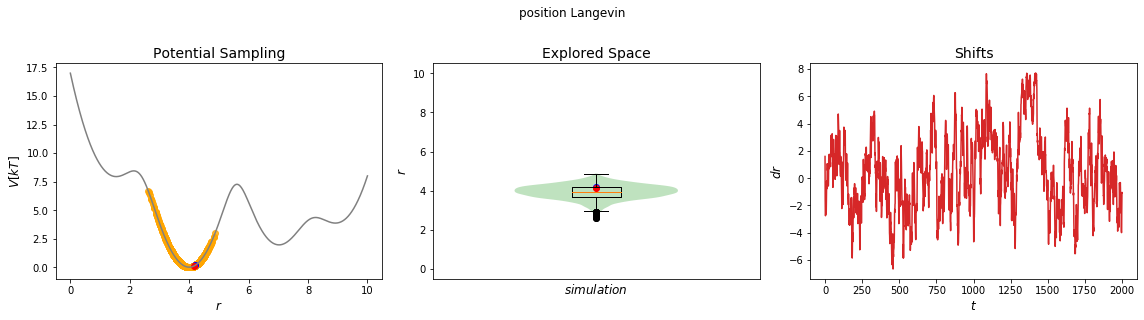

In [44]:
#plot
static_sim_plots(system1, title="position Langevin", limits_coordinate_space=list(range(0,10)))

## Enhanced sampling

Enhanced sampling methods can be divided into time-independent and time-dependent methods. Time-independent biases stay the same throughout the whole simulation whereas for time-dependent enhanced sampling the bias is updated during the simulation time.

### Time-independent bias

Umbrella sampling is a time-independent enhanced sampling method where energy barriers are overcome by adding a bias potential. Note that umbrella sampling requires the choice of a reaction coordinate along which the bias is added. The choice of a suitable reaction coordinate is non-trivial for high dimensional systems. For our low dimensional 1D we can simply chose the x-axis.

One of the most frequent umbrella sampling method uses hormonic potentials to restrain the sampling to a certain region of the potential. This is especially useful for sampling transition regions.

#### Umbrella sampling

We start as in the unbiased case by defining the potential. However, we have to define two potentials; the original potential and the bias potential. The original potential is the same potential as defined above, the bias potential is a hormonic oscillator centered at $x_{shift}$ and force constant $k$. In this case we want to sample the transition region around $x$ = 5.5. Therefore, we set the $x_{shift}$ parameter to 5.5. The force constant $k$ defines how much we constrain the system. The higher the energy barrier, the more constrain is needed. 

To sample the full potential energy landscape, we can set up multiple simulations with different $x_{shift}$ parameters. For subsequent analysis of umbrella sampling simulations (e.g. using the weighted histogram analysis method WHAM) it is important that the sampling space of the different simulations overlap. The higher the force constant $k$, the more simulations are needed achieve the overlap.

In [45]:
#Simulation Setup
origpot = fourWellPotential(Vmax=4, a=1.5, b=4.0, c=7.0, d=9.0,  ah=2., bh=0., ch=0.5, dh=1.)
biaspot = harmonicOscillatorPotential(k=10, x_shift=5.5)

The `addedPotentials` function of the biasOneD class wraps any two 1D potentials together. Therefore, it is straightforward to generate the enhanced sampling system from the original and biased potential.

In [46]:
#Add the bias and the original system
totpot = addedPotentials(origpot, biaspot)

All subsequent steps are identical to the unbiased system. Note, that the starting position of the simulation has to match to the $x_{shift}$ parameter (i.e. should be reasonable close to $x_{shift}$) in order to avoid starting the simulation at very high energy states.

In [47]:
integrator = langevinIntegrator(dt=0.1, gamma=15)
system2=system(potential=totpot, sampler=integrator,  start_position=4.2,  temperature=1)

#simulate
sim_steps = 2000
cur_state = system2.simulate(sim_steps, withdraw_traj=True, init_system=False)

print("Trajectory length: ",len(system2.trajectory))
print()
print("last_state: ", cur_state)
print(len(system2.trajectory))
system2.trajectory.head()

initializing Langevin old Positions	 



Trajectory length:  2001

last_state:  State(position=4.3884192854534865, temperature=1, total_system_energy=6.7783091520320795, total_potential_energy=6.7783091520320795, total_kinetic_energy=nan, dhdpos=5.5846250381244875, velocity=None)
2001


<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: i

,position,temperature,total_system_energy,total_potential_energy,total_kinetic_energy,dhdpos,velocity
0,4.200000,1.0,8.615987,8.608622,0.007365,-11.404041,0.121368
1,4.185677,1.0,8.773799,8.773799,NaN,11.404041,NaN
2,4.232777,1.0,8.244476,8.244476,NaN,11.661214,NaN
3,4.288743,1.0,7.667265,7.667265,NaN,10.815643,NaN
4,4.358204,1.0,7.028987,7.028987,NaN,9.811539,NaN


In order to visualize the original potential, biased potential and the resulting potential we defined a new plotting function `static_sim_plots_bias`. The first panel shows the energy surfaces of the system as well as its sampled fraction. The original energy surface is displayed in red, the added biased one in grey and the resulting energy surface in blue. The positions sampled are shown with orange dots. The middle panel shows a violin plot with the probability density for the sampled points. This plot can be used as a sanity check for the system; for converged systems this plot should show higher probability densities at energy minima and little at high energy regions (following a Boltzmann distribution). The last panel shows the force experienced by the system over time.

<string>:2: RuntimeWarning: divide by zero encountered in log
<string>:2: RuntimeWarning: divide by zero encountered in log


{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001FFE9502988>]}


(None, <Figure size 1152x288 with 3 Axes>)

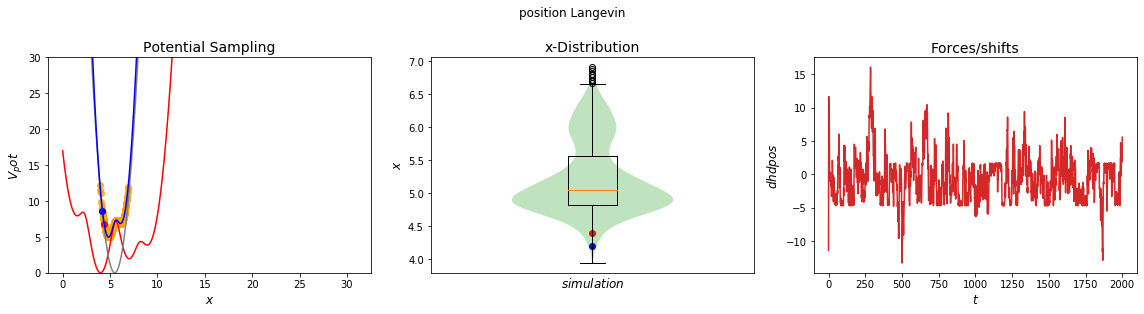

In [48]:
#plot
static_sim_plots_bias(system2, title="position Langevin", limits_coordinate_space=list(range(0,10)), limits_potential_system_energy=[0,30])

With the visualization we can see that umbrella sampling enables the user to sample the high energy transition region around x=5.5. In contrast, the unbiased simulation (see above) was stuck at the minimum around x=4.   

##### Scaled potential

`addedPotentials` can add any potential classes with a given dimensionality. In the special case of adding the same energy potential that was used to define the original system, one can scale the potential. In the example below we chose a four well potential that we will scale down in order to cross the energy barriers more easily. The procedure to define the original and bias potential are the same as described above.

In [49]:
sim_steps = 2000

#Simulation Setup
origpot=fourWellPotential(Vmax=4, a=1.5, b=4.0, c=7.0, d=9.0,  ah=2., bh=0., ch=0.5, dh=1.)
biaspot = fourWellPotential(Vmax=-3.5, a=1.5, b=4.0, c=7.0, d=9.0,  ah=2., bh=0., ch=0.5, dh=1.)
#Add the bias and the original system
totpot = addedPotentials(origpot, biaspot)

integrator = langevinIntegrator(dt=0.1, gamma=15)

system3=system(potential=totpot, sampler=integrator,  start_position=4.2,  temperature=1)

#simulate
cur_state = system3.simulate(sim_steps, withdraw_traj=True, init_system=False)

print("Trajectory length: ",len(system3.trajectory))
print()
print("last_state: ", cur_state)
print(len(system3.trajectory))
system3.trajectory.head()

initializing Langevin old Positions	 



Trajectory length:  2001

last_state:  State(position=0.846972925597466, temperature=1, total_system_energy=1.212949865987629, total_potential_energy=1.212949865987629, total_kinetic_energy=nan, dhdpos=0.747962250791645, velocity=None)
2001


<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: i

,position,temperature,total_system_energy,total_potential_energy,total_kinetic_energy,dhdpos,velocity
0,4.200000,1.0,0.020068,0.019828,0.00024,0.199495,0.021922
1,4.094335,1.0,0.004302,0.004302,NaN,-0.199495,NaN
2,3.866576,1.0,0.008630,0.008630,NaN,-0.094347,NaN
3,3.827922,1.0,0.014483,0.014483,NaN,0.132253,NaN
4,3.846350,1.0,0.011508,0.011508,NaN,0.170615,NaN


{'bodies': [<matplotlib.collections.PolyCollection object at 0x000001FFE982AE08>]}


(None, <Figure size 1152x288 with 3 Axes>)

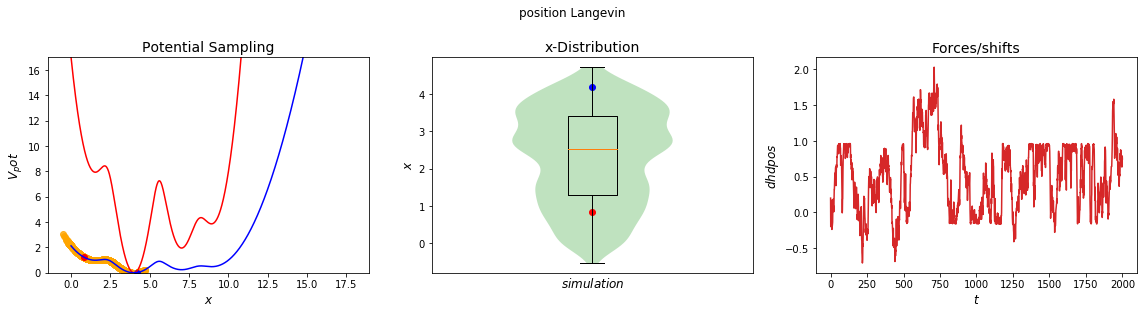

In [50]:
#plot
static_sim_plots_bias(system3, title="position Langevin", limits_coordinate_space=list(range(0,10)), limits_potential_system_energy=[0,17])

Through the visualization we get the confirmation that we scaled the original potential (first panel, red line) down to 12.5% of its original height. Accordingly, the system has now enough thermal energy to cross all energy barriers and all four minima can be sampled.

### Time-dependent bias

Time-dependent biasing methods update the bias during the simulation time. A frequently used time-dependent method is metadynamics/local elevation. There, a gaussian potential is added to the positions that were already visited during the simulation. Therefore, visiting these positions again, is energetically less favorable then in the previous visit (energetic penal). 

Note that in case of a gaussian bias potential, the mean of the gaussian is set to the current position of the particle and its width should be chosen small enough to avoid a big penal for neighboring states. Step by step the energetic minima are "flooded" and the particle can cross barriers more easily. In most applications the bias is only added every $n^{th}$ step to iterate between free diffusion and biasing steps.

#### Metadynamics / Local elevation

We first define the original four-well potential. To apply metadynamics/local elevation we use the `metadynamicsPotential` function. In the initialization we have to define the height ($amplitude$) and width ($sigma$) of the gaussian bias function added. This bias potential is added every $n\_trigger$ steps to the current position. 

Adding more and more potentials every step leads to an energy function that demands more and more computation time every step. To avoid slowdown of the simulation the metadynamic bias is usually stored and calculated grid based. This allow a much faster simulation but comes at the cost of additional input parameter and small numerical errors in the bias force calculations. To initialize the grid, the user has to define the minimum x-position ($bias\_grid\_min$) and the maximum x-position ($bias\_grid\_max$) the grid should cover as well as the number of grid bins. Note, that no bias. will be added to values below $bias\_grid\_min$ or above $bias\_grid\_max$.

In our example system we want to sample all four energy minima. Therefore, it is sufficient to set the grid between 0 and 10, which covers all four minima.

For the metadynamics/local elevation simulation we will reduce the simulation length by the factor of 10. This makes it easier to visually distinguish, and thus understand, the effect of metadynamics/local elevation.

In [51]:
sim_steps = 200  # reduced simulation length

#Simulation Setup
origpot = fourWellPotential(Vmax=4, a=1.5, b=4.0, c=7.0, d=9.0,  ah=2., bh=0., ch=0.5, dh=1.)

#Performe metadynamics
totpot = metadynamicsPotential(origpot, amplitude=.5, sigma=0.2, n_trigger=5, bias_grid_min=0, bias_grid_max=10, numbins=1000)

integrator = langevinIntegrator(dt=0.1, gamma=15)

system4=system(potential=totpot, sampler=integrator,  start_position=4,  temperature=.3)

#simulate
cur_state = system4.simulate(sim_steps, withdraw_traj=True, init_system=False)

print("Trajectory length: ",len(system4.trajectory))
print()
print("last_state: ", cur_state)
print(len(system4.trajectory))
system4.trajectory.head()


initializing Langevin old Positions	 



Trajectory length:  201

last_state:  State(position=4.755214911772379, temperature=0.3, total_system_energy=3.9063318403879723, total_potential_energy=3.9063318403879723, total_kinetic_energy=nan, dhdpos=1.6287267242949355, velocity=None)
201


<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in multiply
<string>:2: RuntimeWarning: invalid value encountered in add
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: i

,position,temperature,total_system_energy,total_potential_energy,total_kinetic_energy,dhdpos,velocity
0,4.000000,0.3,0.005071,-0.001344,0.006415,0.003428,0.113271
1,3.989736,0.3,0.498900,0.498900,NaN,-0.003428,NaN
2,4.100440,0.3,0.462666,0.462666,NaN,0.019121,NaN
3,4.057411,0.3,0.486052,0.486052,NaN,0.416937,NaN
4,4.180715,0.3,0.439768,0.439768,NaN,0.312832,NaN


It is not necessary to show the bias potential for metadynamic/local elevation systems, because the bias is updated during the simulation time. Therefore, metadynamic systems are visualized with the default `static_sim_plots` function. `static_sim_plots` will display the resulting potential after the last simulation step.

(<Figure size 1152x288 with 3 Axes>, None)

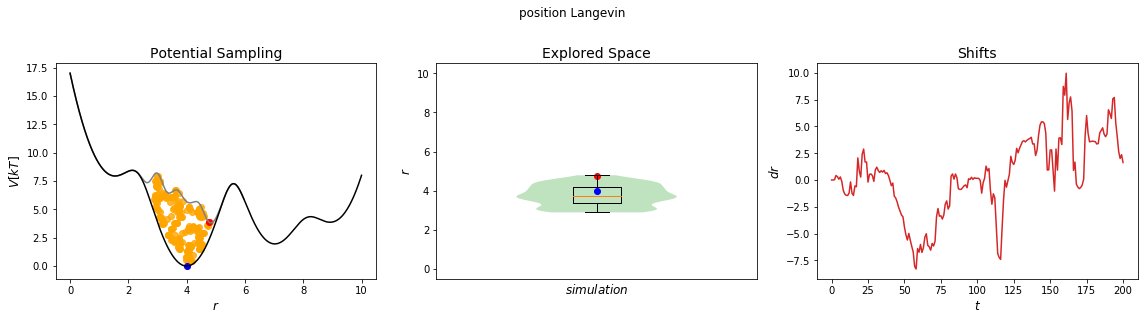

In [52]:
#plot
static_sim_plots(system4, title="position Langevin", limits_coordinate_space=list(range(0,10)))

In the first panel of the visualization we can see how the system's energy minimum around x=4 was flooded and the particle can cross neighboring energy barriers more easily. The longer one simulates, the flatter the whole energy surface become. Note however, that artifacts can arise once the system leaves the grid defined by $bias\_grid\_min$ and $bias\_grid\_max$. Therefore, these parameters have to be selected very carefully.


The Ensembler package also contains a build-in functionality to make short movies of the simulation using `animation_trajectory`. An example code is shown below.

In [53]:
%matplotlib inline
import tempfile
from IPython.display import HTML
from ensembler.visualisation.animationSimulation import animation_trajectory, animation_EDS_trajectory
#plot simulation
ani, out_path = animation_trajectory(system4, x_range=list([0,10]), title="Awesome MetaDynamics",)

##put it into jupyter:

os.chdir(tempfile.gettempdir())
x = ani.to_jshtml()
HTML(x)

AttributeError: 'DataFrame' object has no attribute 'totPotEnergy'

## 2D systems

Enhanced sampling can also be performed in 2D. In the subsequent examples we show for the same enhanced sampling methods as above, how to set up, bias and visualize 2D systems.

To keep the usage of Ensembler as simple as possible, using 2D systems only requires minor changes with regard to 1D systems. Therefore, the description of the 2D systems are kept short. A more detailed description can be found at the corresponding 1D system.

### Unbiased system

We first simulate the 2D system without any bias. In order to perform a 2D simulation, one simply has to choose a 2D potential. The Ensembler package then automatically adjusts all other parameters. If one wishes to set initial coordinates or velocities for the simulation, those should be 2D array.


In [63]:
sim_steps = 2000

#Simulation Setup
origpot = wavePotential2D(amplitude=(100,100), multiplicity=[1/5.,1/5.], radians=True)

integrator = langevinIntegrator(dt=0.1, gamma=15)

system5=system(potential=origpot, sampler=integrator,  start_position=np.array([50,50]),  temperature=3)
system.conditions = []
#simulate
cur_state = system5.simulate(sim_steps, withdraw_traj=True, init_system=False)

print("Trajectory length: ",len(system5.trajectory))
print()
print("last_state: ", cur_state)
print(len(system5.trajectory))
system5.trajectory.head()

initializing Langevin old Positions	 



Trajectory length:  2001

last_state:  State(position=array([45.67254395, 46.02871974]), temperature=3, total_system_energy=array(-193.42746718), total_potential_energy=array(-193.42746718), total_kinetic_energy=nan, dhdpos=array([6.41194217, 4.5769616 ]), velocity=None)
2001


,position,temperature,total_system_energy,total_potential_energy,total_kinetic_energy,dhdpos,velocity
0,"[50, 50]",3,-167.807,-167.81430581529048,0.00766,"[10.880422217787395, 10.880422217787395]","[-0.07848694955981567, -0.0957059670725772]"
1,"[49.70682166327176, 49.615967630207905]",3,-174.78513625995924,-174.78513625995924,NaN,"[-10.880422217787395, -10.880422217787395]",None
2,"[49.70672792572797, 49.21059120934928]",3,-178.36897812059397,-178.36897812059397,NaN,"[-9.878296732257812, -9.560689302311934]",None
3,"[49.790858998466504, 49.04031355574947]",3,-178.85276527808622,-178.85276527808622,NaN,"[-9.877970707488545, -8.10660907484373]",None
4,"[49.50709544705879, 48.98920548258358]",3,-181.97562694323517,-181.97562694323517,NaN,"[-10.169173048070686, -7.4793778881081066]",None


In [62]:
system5.potential

After the simulation we can visualize the simulation on the 2D energy surface.

In the visualization, we can see that the system contains multiple energy minima and maxima. The simulation was started in a minimum. During the simulation time the simulated particle is unable to leave this start minimum.

In [ ]:
test_timing_with_points = 100
positions = np.linspace(0, 100, test_timing_with_points)
x_positions, y_positions = np.meshgrid(positions,positions)
positions2D = np.array([x_positions.flatten(), y_positions.flatten()]).T

traj_pos = np.array(list(map(lambda x: np.array(x), system5.trajectory.position))).T

plt.imshow(origpot.ene(positions2D).reshape([test_timing_with_points,test_timing_with_points]))
plt.scatter(*traj_pos, color="orange")

### Umbrella Sampling

Umbrella sampling is performed with the `addedPotential2D` function that works analogous to the `addedPotential` function for 1D. However, it expects two 2D potentials as input. Here we make umbrella sampling with a harmonic potential centered around point [10,5]. If needed, one can define different spring constants in x and y direction.

In [ ]:
sim_steps = 2000

#Simulation Setup
origpot = wavePotential2D(amplitude=(100,100), multiplicity=[1/5.,1/5.], radians=True)
biaspot = harmonicOscillator2D(k=np.array([10,10]), r_shift=np.array([10,5])) 

#Add the bias and the original system
totpot = addedPotentials2D(origpot, biaspot)

integrator = langevinIntegrator(dt=0.1, gamma=15)

system6=system(potential=totpot, sampler=integrator,  start_position=np.array([50,50]),  temperature=3)

#simulate
cur_state = system6.simulate(sim_steps, withdraw_traj=True, init_system=False)

print("Trajectory length: ",len(system6.trajectory))
print()
print("last_state: ", cur_state)
print(len(system6.trajectory))
system6.trajectory.head()

In the visualization we see that the energy minimum of the resulting (original + biased) energy surface is the chosen point [10,10]. The system quickly leaves its start region, moves toward the center point, and samples this region intensively. Therefore, using umbrella sampling, the system was able to escape its starting minimum.

In [54]:
test_timing_with_points=100
positions = np.linspace(0, 100, test_timing_with_points)
x_positions, y_positions = np.meshgrid(positions,positions)
positions2D = np.array([x_positions.flatten(), y_positions.flatten()]).T

traj_pos = np.array(list(map(lambda x: np.array(x), system6.trajectory.position))).T

plt.imshow(totpot.ene(positions2D).reshape([test_timing_with_points,test_timing_with_points]))
plt.scatter(*traj_pos, color="orange")

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

### Scaled potential

Just like in the 1D case, the `addedPotential2D` function can be used to scale potentials. Here we scale our system to lower the energy barriers between the minima.

In [ ]:
sim_steps = 2000

#Simulation Setup
origpot = wavePotential2D(amplitude=(100,100), multiplicity=[1/5.,1/5.], degree=False)
biaspot = wavePotential2D(amplitude=(-99.8,-99.8), multiplicity=[1/5.,1/5.], degree=False)

#Add the bias and the original system
totpot = addedPotentials2D(origpot, biaspot)

integrator = langevinIntegrator(dt=0.1, gamma=15)

system7=system(potential=totpot, sampler=integrator,  start_position=np.array([50,50]),  temperature=3)

#simulate
cur_state = system7.simulate(sim_steps, withdraw_traj=True, init_system=False)

print("Trajectory length: ",len(system7.trajectory))
print()
print("last_state: ", cur_state)
print(len(system7.trajectory))
system7.trajectory.head()

In the visualization we can confirm that the energy barriers are now low enough for the system to escape its initial minimum and sample the neighboring minima. 

In [ ]:
test_timing_with_points=100
positions = np.linspace(0, 100, test_timing_with_points)
x_positions, y_positions = np.meshgrid(positions,positions)
positions2D = np.array([x_positions.flatten(), y_positions.flatten()]).T

traj_pos = np.array(list(map(lambda x: np.array(x), system7.trajectory.position))).T

plt.imshow(totpot.ene(positions2D).reshape([test_timing_with_points,test_timing_with_points]))
plt.scatter(*traj_pos, color="orange")

### Metadynamics / Local elevation

Metadynamics/Local elevation changes the energy surface of the simulation during the simulation time (time dependent bias). Similar to its 1D analog, `metadynamicsPotential2D` uses a grid to store the bias added to the system. The minimal and maximal values of the grid in x and y direction have to be defined by the user. The gaussians added by the metadynamic bias can have elliptical shapes. The shape is defined by the $sigma$ parameter. 

In [ ]:
sim_steps = 2000

#Simulation Setup
origpot = wavePotential2D(amplitude=(100,100), multiplicity=[1/5.,1/5.], radians=True)

#Perform metadynamics
totpot = metadynamicsPotential2D(origpot, amplitude=2, sigma=(5,5), n_trigger=10, bias_grid_min=(0,0), bias_grid_max=(100,100), numbins=(1000,1000))

integrator = langevinIntegrator(dt=0.1, gamma=15)

system8=system(potential=totpot, sampler=integrator,  start_position=np.array([50,50]),  temperature=3)

#simulate
cur_state = system8.simulate(sim_steps, withdraw_traj=True, init_system=False)

print("Trajectory length: ",len(system8.trajectory))
print()
print("last_state: ", cur_state)
print(len(system8.trajectory))
system8.trajectory.head()

From the visualization it is visible that regions which were already visited by the system show a higher energy. Especially the starting minimum is flooded with energy. Using metadynamics the system can rapidly sample the energy surface.  

In [ ]:
test_timing_with_points=100
positions = np.linspace(0, 100, test_timing_with_points)
x_positions, y_positions = np.meshgrid(positions,positions)
positions2D = np.array([x_positions.flatten(), y_positions.flatten()]).T

traj_pos = np.array(list(map(lambda x: np.array(x), system8.trajectory.position))).T


energies_test = np.array([totpot.ene(entry) for entry in positions2D])

plt.imshow(energies_test.reshape([test_timing_with_points,test_timing_with_points]))
plt.scatter(*traj_pos, color="orange")